# Exploring SNSF Public Data

## Foreword

The [Swiss National Science Foundation](http://www.snf.ch/en/Pages/default.aspx) (SNSF) is the leading public science funding agency in Switzerland.  In _GrantExport_, the SNSF provides detailed information about approved grants.  In _PersonExport_, it also provides details about people associated to each grant.  Other tables provide further data about publications, outputs, and collaborations reported by applicants.  You can find the datasets and their documentation in [p3.snf.ch](http://p3.snf.ch/Pages/DataAndDocumentation.aspx).

Prior to exploring the data, I performed some cleaning operations on _GrantExport_ and on _PersonExport_.

In this notebook, we will look at the data in _GrantExport_ and _PersonExport_ and try to get some insights on how funding differs for men and women.

In [1]:
import os
import sqlite3

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(12, 8)})

DATA_FOLDER = '../data'

In [2]:
conn = sqlite3.connect(os.path.join(DATA_FOLDER, 'p3.db'),
                       detect_types=sqlite3.PARSE_DECLTYPES)
grants = pd.read_sql_query('SELECT * FROM grants;', conn)
grantees = pd.read_sql_query('SELECT * FROM role_in_grants;', conn)
people = pd.read_sql_query('SELECT * FROM people;', conn)

## Overview

Quick inspection of each dataset, one-by-one.

In [3]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111120 entries, 0 to 111119
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   person_id_snsf  111120 non-null  int64 
 1   gender          111120 non-null  object
 2   first_name      111113 non-null  object
 3   last_name       111120 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


In [4]:
grantees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255507 entries, 0 to 255506
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   person_id_snsf  255507 non-null  int64 
 1   role            255507 non-null  object
 2   project_number  255507 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.8+ MB


In [5]:
grants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74517 entries, 0 to 74516
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   project_number      74517 non-null  int64         
 1   programme           74477 non-null  object        
 2   funding_instrument  74517 non-null  object        
 3   domain              74018 non-null  object        
 4   topic               70746 non-null  object        
 5   discipline_name     74517 non-null  object        
 6   discipline_number   74517 non-null  int64         
 7   start_date          74517 non-null  datetime64[ns]
 8   end_date            74517 non-null  datetime64[ns]
 9   approved_amount     61385 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 5.7+ MB


In [6]:
assert any(grants.project_number.duplicated()) == False, 'project_number contains duplicated entries'

In [7]:
# time range
grants.start_date.min(), grants.end_date.max()

(Timestamp('1975-01-06 00:00:00'), Timestamp('2025-10-31 00:00:00'))

_GrantExport_ contains ca. 74.5k grants, spanning across 50 years, from 1975 to 2025.

### Temporal trends

#### Approved grants

In [8]:
grants['year'] = grants['start_date'].dt.year

<AxesSubplot:title={'center':'Number of grants per year'}>

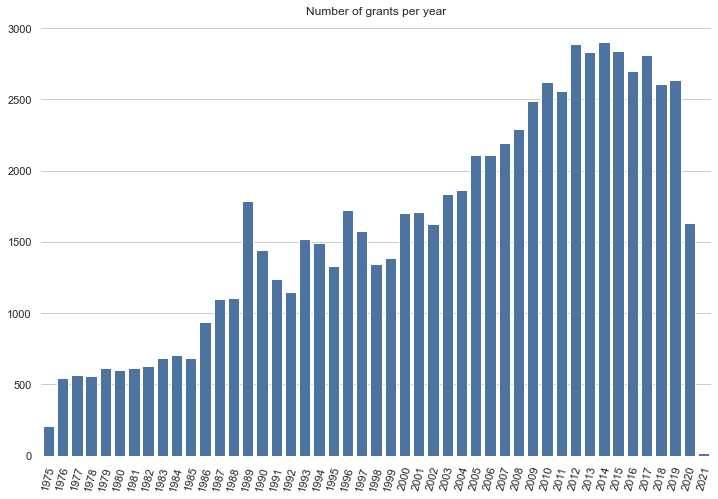

In [9]:
sns.set_style("whitegrid")
plt.box(on=None) 
g = sns.countplot(x='year', data=grants, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')
g.set_title('Number of grants per year')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center')
g;

The number of grants nearly duplicated in 20 years.

#### Funding commitments

<AxesSubplot:title={'center':'Annual grant funding commitments'}>

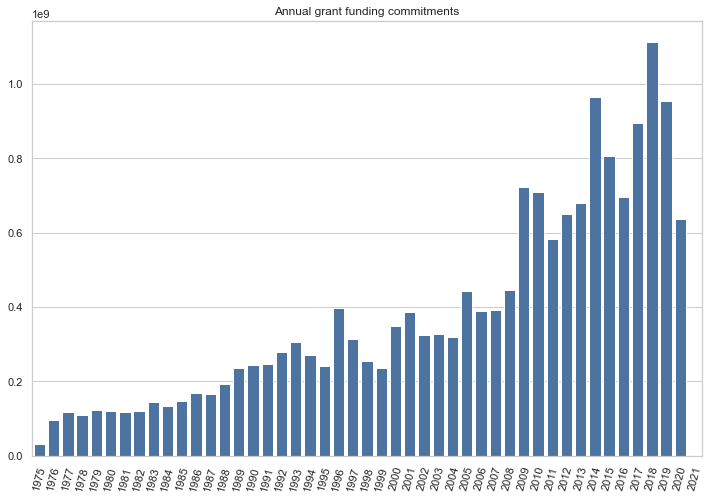

In [10]:
annual_funding = grants.groupby(['year'])['approved_amount'].sum().reset_index()
g = sns.barplot(x='year', y='approved_amount', data=annual_funding, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')    
g.set_title('Annual grant funding commitments')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center', fontweight='light')
g;

In [11]:
annual_counts = grants.groupby(['year']).size().reset_index().rename(columns={0:'count'})
annual_stats = annual_counts.merge(annual_funding, on='year')
annual_stats = annual_stats.query('year < 2020')

<AxesSubplot:xlabel='Grants Approved', ylabel='Total Commitments'>

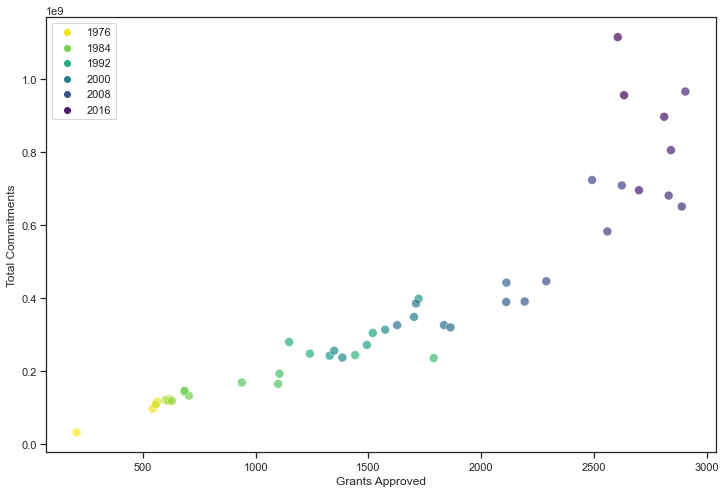

In [12]:
sns.set_style("ticks")
g = sns.scatterplot(x="count", y="approved_amount", hue=annual_stats.year.tolist(), palette='viridis_r', alpha=.7, s = 80, data=annual_stats)
g.set_xlabel('Grants Approved')
g.set_ylabel('Total Commitments')  
g;

A scatterplot between the annual funding commitments and the grants approved shows a higher spread in more recent years.

## Role and gender

In this section, we consider both the role and the gender of the person involved in the project.  The totals are the following:

In [13]:
(grantees
 .merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
 .groupby(['gender', 'role']).size())

gender  role                 
female  applicant                 6533
        contact_person             217
        employee                 50596
        partner                   1522
        practice_partner           253
        responsible_applicant    15614
male    applicant                40076
        contact_person             816
        employee                 76904
        partner                   4439
        practice_partner           543
        responsible_applicant    57994
dtype: int64

In [14]:
workforce = (grantees
   .merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
   .merge(grants, on='project_number')
   .loc[:, "person_id_snsf":"domain"])

In [15]:
projects_with_employees = (workforce
 .query('role in ["responsible_applicant", "employee"]')
 .groupby(['project_number', 'role'])
 .size()
 .reset_index(name="n")
 .pivot_table(index="project_number", columns="role", values="n", fill_value=0)
 .query('responsible_applicant > 0')
 .query('employee > 0'))

In [16]:
# remove Careers and Science communication from grants
grant_selection = (workforce
   .merge(projects_with_employees, on="project_number")
   .query('role in ["responsible_applicant", "employee"]')
   .query('programme in ["Infrastructure", "Programmes", "Project funding"]')[['project_number']]
   .drop_duplicates()
   .reset_index(drop=True)
)

In [17]:
grants = grants.merge(grant_selection, on = "project_number")

### Project leaders

A project leader is a scientist where `role == 'responsible_applicant'`.

In [18]:
# grants represented by their main applicants
pi = grantees.query('role == "responsible_applicant"').merge(grants, on='project_number')
# adding gender from people table
pi = pi.merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')

In [19]:
annual_counts = pi.groupby(['year', 'gender']).size().reset_index().rename(columns={0:'count'})
annual_funding = pi.groupby(['year', 'gender'])['approved_amount'].sum().reset_index()
annual_stats = annual_counts.merge(annual_funding, on=['year', 'gender'])
annual_stats = annual_stats.query('year < 2020')

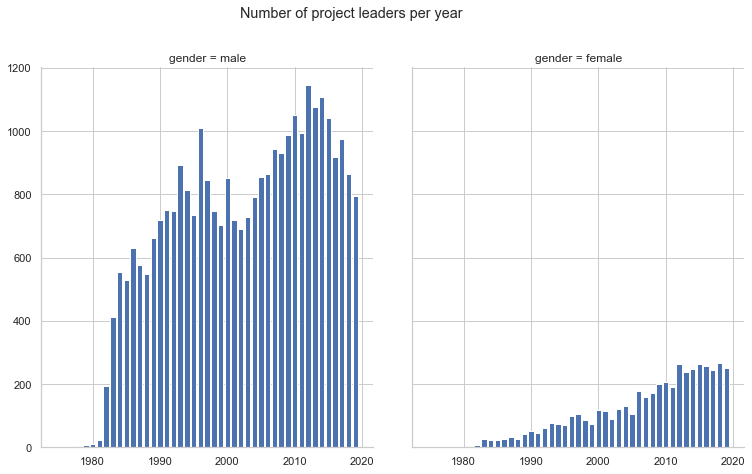

In [20]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project leaders per year')
g;

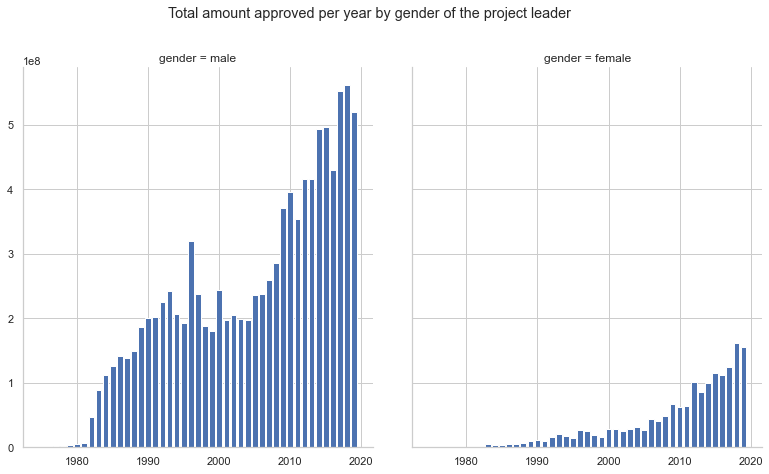

In [21]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'approved_amount')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Total amount approved per year by gender of the project leader')
g;

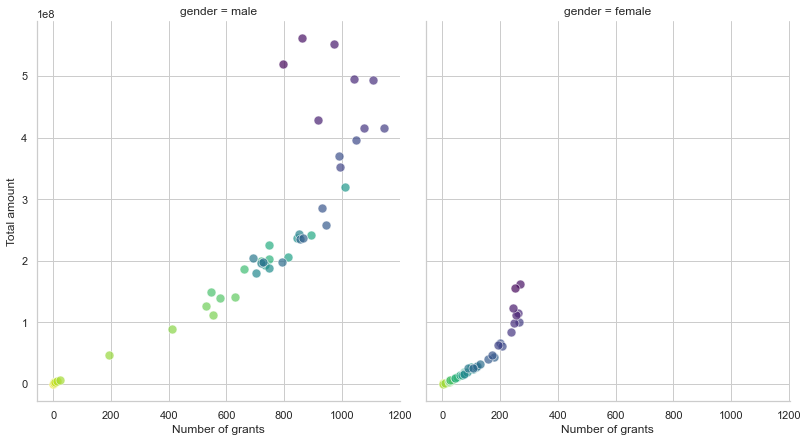

In [22]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', hue='year', palette='viridis_r', data=annual_stats)
g.map(sns.scatterplot, 'count', 'approved_amount', alpha=.7, s=80)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels("Number of grants", "Total amount")
g;

### Project employees

In [23]:
workforce = grantees.query('role == "employee"').merge(grants, on='project_number')
workforce = workforce.merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')

In [24]:
annual_counts = workforce.groupby(['year', 'gender']).size().reset_index().rename(columns={0:'count'})
annual_counts = annual_counts.query('year < 2020')

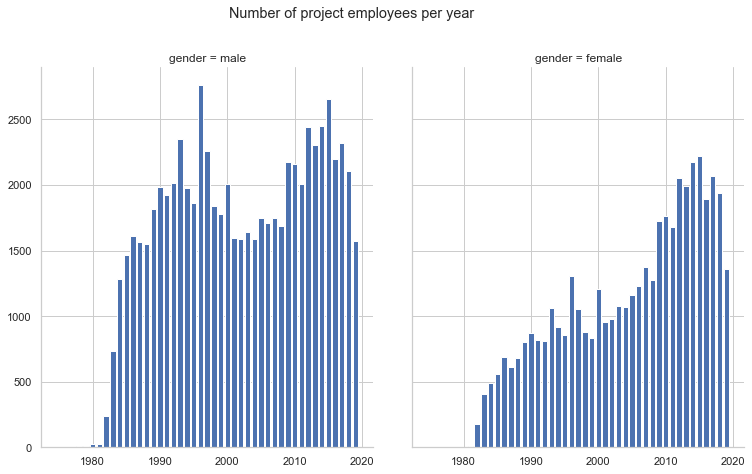

In [25]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_counts)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project employees per year')
g;